# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
import numpy as np
import pandas as pd

# Load the datasets
data_wine = pd.read_csv("wine.csv")
data_heart = pd.read_csv("heart.csv")
data_car = pd.read_csv("car.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Define the grow_tree function
def grow_tree(X, y, max_depth, current_depth=0):
    # Base case: if the maximum depth is reached or all labels are the same, return a leaf node
    if current_depth >= max_depth or len(set(y)) == 1:
        return np.argmax(np.bincount(y))  # Return the most common class

    # Find the best feature to split on
    best_feature = find_best_feature(X, y)

    # Split the data based on the best feature
    X_left, X_right, y_left, y_right = split_data(X, y, best_feature)

    # If no split is possible, return a leaf node
    if len(y_left) == 0 or len(y_right) == 0:
        return np.argmax(np.bincount(y))  # Return the most common class

    # Recursively grow the left and right subtrees
    left_child = grow_tree(X_left, y_left, max_depth, current_depth + 1)
    right_child = grow_tree(X_right, y_right, max_depth, current_depth + 1)

    # Return the current node
    return {
        "feature": best_feature,
        "left_child": left_child,
        "right_child": right_child
    }

# Define the find_best_feature function
def find_best_feature(X, y):
    # Calculate the information gain for each feature
    gains = []
    for i in range(X.shape[1]):
        gain = calculate_information_gain(X[:, i], y)
        gains.append(gain)

    # Return the feature with the highest information gain
    return np.argmax(gains)

# Define the calculate_information_gain function
def calculate_information_gain(X, y):
    # Calculate the entropy of the target variable
    entropy_y = calculate_entropy(y)

    # Calculate the conditional entropy of the target variable given the feature
    conditional_entropy_y_given_X = calculate_conditional_entropy(X, y)

    # Return the information gain
    return entropy_y - conditional_entropy_y_given_X

# Define the calculate_entropy function
def calculate_entropy(y):
    # Calculate the probability of each class
    probabilities = np.bincount(y) / len(y)

    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add a small value to avoid log(0)

    return entropy

# Define the calculate_conditional_entropy function
def calculate_conditional_entropy(X, y):
    # Calculate the unique values and their counts for the feature
    unique_values = np.unique(X)
    total_count = len(y)

    # Calculate the conditional entropy
    conditional_entropy = 0
    for value in unique_values:
        subset_y = y[X == value]
        prob = len(subset_y) / total_count
        conditional_entropy += prob * calculate_entropy(subset_y)

    return conditional_entropy

# Define the split_data function
def split_data(X, y, feature):
    # Split the data based on the feature
    threshold = np.mean(X[:, feature])  # Use the mean as the threshold for splitting
    X_left = X[X[:, feature] < threshold]
    X_right = X[X[:, feature] >= threshold]
    y_left = y[X[:, feature] < threshold]
    y_right = y[X[:, feature] >= threshold]

    return X_left, X_right, y_left, y_right

# Encode the features and target variables for each dataset
X_wine = encode_features(data_wine.iloc[:, :-1])
y_wine, _ = encode_labels(data_wine.iloc[:, -1])

X_heart = encode_features(data_heart.iloc[:, :-1])
y_heart, _ = encode_labels(data_heart.iloc[:, -1])

X_car = encode_features(data_car.iloc[:, :-1])
y_car, _ = encode_labels(data_car.iloc[:, -1])

# Grow the tree for each dataset
tree_wine = grow_tree(X_wine, y_wine, max_depth=5)

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [3]:
import numpy as np
import pandas as pd

# Load the datasets
data_wine = pd.read_csv("wine.csv")
data_heart = pd.read_csv("heart.csv")
data_car = pd.read_csv("car.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Stopping criteria functions
def stop_single_class(y):
    return len(set(y)) == 1  # True if all classes are the same

def stop_max_depth(current_depth, max_depth):
    return current_depth >= max_depth  # True if max depth is reached

def stop_min_samples(y, min_samples):
    return len(y) < min_samples  # True if the number of samples is less than min_samples

def stop_unbalanced(y, threshold=0.9):
    class_counts = np.bincount(y)
    total_count = len(y)
    if total_count == 0:
        return False
    max_class_count = np.max(class_counts)
    return (max_class_count / total_count) > threshold  # True if one class dominates

# Define the grow_tree function
def grow_tree(X, y, max_depth, min_samples, current_depth=0):
    # Check stopping conditions
    if stop_single_class(y):
        return np.argmax(np.bincount(y))  # Return the most common class
    if stop_max_depth(current_depth, max_depth):
        return np.argmax(np.bincount(y))  # Return the most common class
    if stop_min_samples(y, min_samples):
        return np.argmax(np.bincount(y))  # Return the most common class
    if stop_unbalanced(y):
        return np.argmax(np.bincount(y))  # Return the most common class

    # Find the best feature to split on
    best_feature = find_best_feature(X, y)

    # Split the data based on the best feature
    X_left, X_right, y_left, y_right = split_data(X, y, best_feature)

    # If no split is possible, return a leaf node
    if len(y_left) == 0 or len(y_right) == 0:
        return np.argmax(np.bincount(y))  # Return the most common class

    # Recursively grow the left and right subtrees
    left_child = grow_tree(X_left, y_left, max_depth, min_samples, current_depth + 1)
    right_child = grow_tree(X_right, y_right, max_depth, min_samples, current_depth + 1)

    # Return the current node
    return {
        "feature": best_feature,
        "left_child": left_child,
        "right_child": right_child
    }

# Define the find_best_feature function
def find_best_feature(X, y):
    # Calculate the information gain for each feature
    gains = []
    for i in range(X.shape[1]):
        gain = calculate_information_gain(X[:, i], y)
        gains.append(gain)

    # Return the feature with the highest information gain
    return np.argmax(gains)

# Define the calculate_information_gain function
def calculate_information_gain(X, y):
    # Calculate the entropy of the target variable
    entropy_y = calculate_entropy(y)

    # Calculate the conditional entropy of the target variable given the feature
    conditional_entropy_y_given_X = calculate_conditional_entropy(X, y)

    # Return the information gain
    return entropy_y - conditional_entropy_y_given_X

# Define the calculate_entropy function
def calculate_entropy(y):
    # Calculate the probability of each class
    probabilities = np.bincount(y) / len(y)

    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add a small value to avoid log(0)

    return entropy

# Define

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [4]:
def best_feature_to_split(X, y):
    """
    Calculate the best feature to split on using Information Gain.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - y: numpy array of shape (n_samples,)
    
    Returns:
    - best_feature: index of the feature with the highest Information Gain
    """
    best_gain = -1
    best_feature = -1
    n_features = X.shape[1]
    
    # Calculate the entropy of the target variable
    base_entropy = calculate_entropy(y)

    for feature in range(n_features):
        # Get unique values for the feature
        unique_values = np.unique(X[:, feature])
        
        # If the feature is categorical
        if len(unique_values) < 10:  # Arbitrary threshold for categorical features
            # Calculate the conditional entropy for categorical features
            conditional_entropy = 0
            for value in unique_values:
                subset_y = y[X[:, feature] == value]
                prob = len(subset_y) / len(y)
                conditional_entropy += prob * calculate_entropy(subset_y)
        else:
            # If the feature is continuous, we need to find the best threshold
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2  # Midpoints for thresholds
            conditional_entropy = float('inf')  # Start with a large value
            
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = X[:, feature] >= threshold
                
                if np.any(left_mask) and np.any(right_mask):
                    left_y = y[left_mask]
                    right_y = y[right_mask]
                    prob_left = len(left_y) / len(y)
                    prob_right = len(right_y) / len(y)
                    current_conditional_entropy = (prob_left * calculate_entropy(left_y) +
                                                    prob_right * calculate_entropy(right_y))
                    
                    # Update the conditional entropy if this threshold is better
                    if current_conditional_entropy < conditional_entropy:
                        conditional_entropy = current_conditional_entropy

        # Calculate Information Gain
        information_gain = base_entropy - conditional_entropy
        
        # Update best feature if this one is better
        if information_gain > best_gain:
            best_gain = information_gain
            best_feature = feature

    return best_feature

# Example usage of the function
# Assuming X and y are defined
# best_feature_index = best_feature_to_split(X, y)

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [5]:
def split_data(X, y, feature):
    """
    Split the data based on the specified feature.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - y: numpy array of shape (n_samples,)
    - feature: index of the feature to split on
    
    Returns:
    - X_left: subset of X for instances where the feature value is less than the mean
    - X_right: subset of X for instances where the feature value is greater than or equal to the mean
    - y_left: subset of y corresponding to X_left
    - y_right: subset of y corresponding to X_right
    """
    # Calculate the mean of the feature for real-valued features
    threshold = np.mean(X[:, feature])
    
    # Create masks for splitting
    left_mask = X[:, feature] < threshold
    right_mask = X[:, feature] >= threshold
    
    # Split the data
    X_left = X[left_mask]
    X_right = X[right_mask]
    y_left = y[left_mask]
    y_right = y[right_mask]

    return X_left, X_right, y_left, y_right

# Example usage of the function
# Assuming X and y are defined
# X_left, X_right, y_left, y_right = split_data(X, y, best_feature_index)

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [6]:
def predict_with_tree(tree, x):
    """
    Predict the class for a single data point using the decision tree.
    
    Parameters:
    - tree: the decision tree (a nested dictionary)
    - x: a single data point (numpy array)
    
    Returns:
    - predicted_class: the predicted class for the data point
    """
    # If the tree is a leaf node, return the predicted class
    if not isinstance(tree, dict):
        return tree  # Return the class label at the leaf node

    # Get the feature index to split on
    feature_index = tree['feature']
    
    # Calculate the threshold for the current feature
    threshold = np.mean(x[feature_index])  # Use the mean for splitting

    # Determine which branch to follow based on the feature value
    if x[feature_index] < threshold:
        return predict_with_tree(tree['left_child'], x)  # Go left
    else:
        return predict_with_tree(tree['right_child'], x)  # Go right

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [7]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [8]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

Final Accuracy of My Decision Tree Model: 0.29
Final Accuracy of Scikit-Learn Decision Tree Model: 0.41


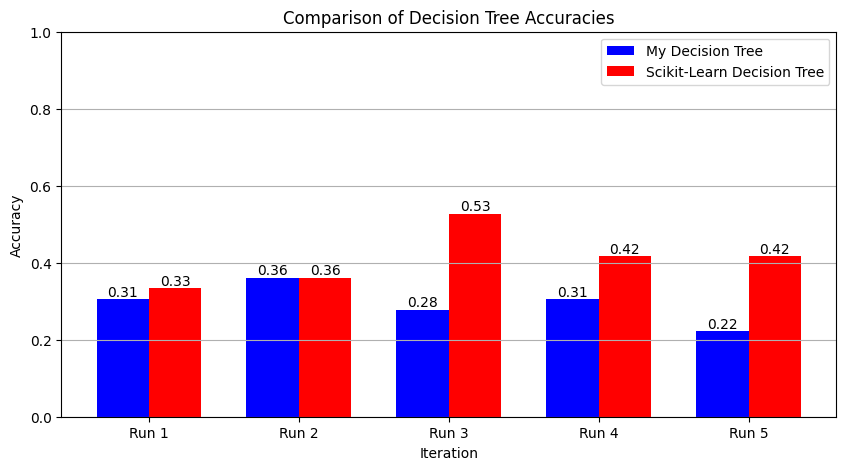

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Load the datasets
data_wine = pd.read_csv("wine.csv")
data_heart = pd.read_csv("heart.csv")
data_car = pd.read_csv("car.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Prepare the datasets
def prepare_data(data):
    X = encode_features(data.iloc[:, :-1])
    y, _ = encode_labels(data.iloc[:, -1])
    return X, y

# Prepare datasets
X_wine, y_wine = prepare_data(data_wine)

# Define the grow_tree function (assuming this function is already defined)
def grow_tree(X, y, max_depth, min_samples, current_depth=0):
    # Check stopping conditions (assuming these functions are defined)
    if stop_single_class(y):
        return np.argmax(np.bincount(y))
    if stop_max_depth(current_depth, max_depth):
        return np.argmax(np.bincount(y))
    if stop_min_samples(y, min_samples):
        return np.argmax(np.bincount(y))
    if stop_unbalanced(y):
        return np.argmax(np.bincount(y))

    # Find the best feature to split on
    best_feature = best_feature_to_split(X, y)

    # Split the data based on the best feature
    X_left, X_right, y_left, y_right = split_data(X, y, best_feature)

    # If no split is possible, return a leaf node
    if len(y_left) == 0 or len(y_right) == 0:
        return np.argmax(np.bincount(y))

    # Recursively grow the left and right subtrees
    left_child = grow_tree(X_left, y_left, max_depth, min_samples, current_depth + 1)
    right_child = grow_tree(X_right, y_right, max_depth, min_samples, current_depth + 1)

    # Return the current node
    return {
        "feature": best_feature,
        "left_child": left_child,
        "right_child": right_child
    }

# Define the predict_with_tree function
def predict_with_tree(tree, x):
    if not isinstance(tree, dict):
        return tree  # Return the class label at the leaf node

    feature_index = tree['feature']
    threshold = np.mean(x[feature_index])  # Use the mean for splitting
    if x[feature_index] < threshold:
        return predict_with_tree(tree['left_child'], x)  # Go left
    else:
        return predict_with_tree(tree['right_child'], x)  # Go right

# Initialize lists to store accuracies
my_tree_accuracies = []
sklearn_accuracies = []

# Number of iterations for testing
n_iterations = 5

# Loop for training and testing
for _ in range(n_iterations):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=None)

    # Train your decision tree model
    my_tree = grow_tree(X_train, y_train, max_depth=5, min_samples=5)

    # Make predictions with your decision tree
    my_predictions = [predict_with_tree(my_tree, x) for x in X_test]
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_tree_accuracies.append(my_accuracy)

    # Train scikit-learn's decision tree model
    sklearn_model = DecisionTreeClassifier(max_depth=5)
    sklearn_model.fit(X_train, y_train)

    # Make predictions with scikit-learn's model
    sklearn_predictions = sklearn_model.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)

# Calculate final accuracy rates
final_my_tree_accuracy = np.mean(my_tree_accuracies)
final_sklearn_accuracy = np.mean(sklearn_accuracies)

# Print final accuracy rates
print(f"Final Accuracy of My Decision Tree Model: {final_my_tree_accuracy:.2f}")
print(f"Final Accuracy of Scikit-Learn Decision Tree Model: {final_sklearn_accuracy:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
x = np.arange(n_iterations)
width = 0.35

# Create bars for both models
bars1 = plt.bar(x - width/2, my_tree_accuracies, width, label='My Decision Tree', color='blue')
bars2 = plt.bar(x + width/2, sklearn_accuracies, width, label='Scikit-Learn Decision Tree', color='red')

# Add accuracy labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies')
plt.xticks(x, [f'Run {i+1}' for i in x])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show() 


### 7) Dataset 2: Heart Disease

Non Error type : {'feature': 12, 'left_child': {'feature': 11, 'left_child': {'feature': 9, 'left_child': 1, 'right_child': {'feature': 9, 'left_child': {'feature': 2, 'left_child': 1, 'right_child': 1}, 'right_child': {'feature': 0, 'left_child': 0, 'right_child': 0}}}, 'right_child': {'feature': 2, 'left_child': {'feature': 10, 'left_child': 0, 'right_child': {'feature': 9, 'left_child': 0, 'right_child': 1}}, 'right_child': {'feature': 9, 'left_child': {'feature': 8, 'left_child': 1, 'right_child': 0}, 'right_child': {'feature': 3, 'left_child': 0, 'right_child': 0}}}}, 'right_child': {'feature': 2, 'left_child': 0, 'right_child': {'feature': 11, 'left_child': {'feature': 9, 'left_child': {'feature': 9, 'left_child': 1, 'right_child': 1}, 'right_child': {'feature': 7, 'left_child': 0, 'right_child': 1}}, 'right_child': {'feature': 6, 'left_child': 0, 'right_child': {'feature': 4, 'left_child': 1, 'right_child': 0}}}}}
Non Error type : {'feature': 2, 'left_child': 0, 'right_child': {

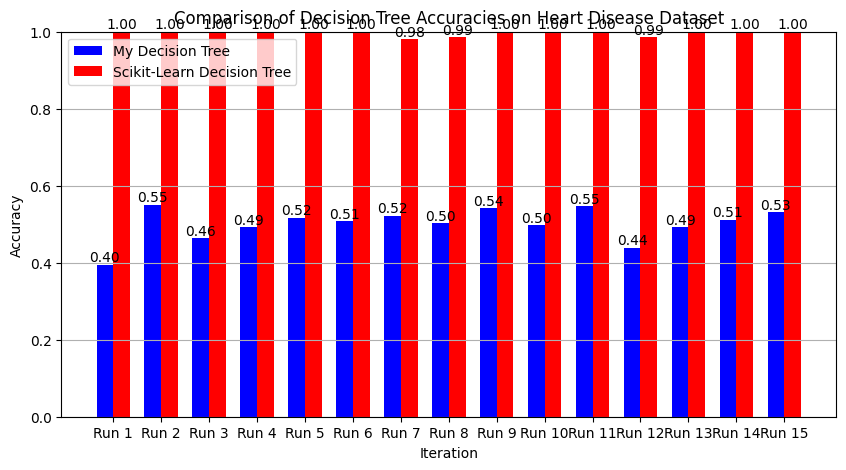

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Load the heart disease dataset
data_heart = pd.read_csv("heart.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Prepare the dataset
def prepare_data(data):
    X = encode_features(data.iloc[:, :-1])
    y, _ = encode_labels(data.iloc[:, -1])
    return X, y

# Prepare the heart dataset
X_heart, y_heart = prepare_data(data_heart)

# Define the grow_tree function (assuming this function is already defined)
def grow_tree(X, y, max_depth, min_samples, current_depth=0):
    # Check stopping conditions (assuming these functions are defined)
    if stop_single_class(y):
        return np.argmax(np.bincount(y))
    if stop_max_depth(current_depth, max_depth):
        return np.argmax(np.bincount(y))
    if stop_min_samples(y, min_samples):
        return np.argmax(np.bincount(y))
    if stop_unbalanced(y):
        return np.argmax(np.bincount(y))

    # Find the best feature to split on
    best_feature = best_feature_to_split(X, y)

    # Split the data based on the best feature
    X_left, X_right, y_left, y_right = split_data(X, y, best_feature)

    # If no split is possible, return a leaf node
    if len(y_left) == 0 or len(y_right) == 0:
        return np.argmax(np.bincount(y))

    # Recursively grow the left and right subtrees
    left_child = grow_tree(X_left, y_left, max_depth, min_samples, current_depth + 1)
    right_child = grow_tree(X_right, y_right, max_depth, min_samples, current_depth + 1)

    # Return the current node
    return {
        "feature": best_feature,
        "left_child": left_child,
        "right_child": right_child
    }

# Define the predict_with_tree function
errorEntries = 0
intError = 0
totalEntries = 0
def predict_with_tree(tree, x):
    global intError
    global errorEntries
    global totalEntries
    totalEntries = totalEntries+1
    if not isinstance(tree, dict):
        # print(f"Error type : {type(tree)} : {tree}")
        if isinstance(tree, np.int64):
            intError = intError+1
        errorEntries = errorEntries+1
        return tree  # Return the class label at the leaf node
    else:
        if(totalEntries<5):
            print(f"Non Error type : {tree}")

    feature_index = tree['feature']
    threshold = np.mean(x[feature_index])  # Use the mean for splitting
    if x[feature_index] < threshold:
        return predict_with_tree(tree['left_child'], x)  # Go left
    else:
        return predict_with_tree(tree['right_child'], x)  # Go right

# Initialize lists to store accuracies
my_tree_accuracies = []
sklearn_accuracies = []

# Number of iterations for testing
n_iterations = 15

# Loop for training and testing
for _ in range(n_iterations):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_heart, y_heart, test_size=0.2, random_state=None)

    # Hyperparameter tuning for scikit-learn's decision tree model
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=0)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions with the best scikit-learn model
    sklearn_predictions = best_model.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)

    # Train your decision tree model
    my_tree = grow_tree(X_train, y_train, max_depth=5, min_samples=10)

    # Make predictions with your decision tree
    my_predictions = [predict_with_tree(my_tree, x) for x in X_test]
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_tree_accuracies.append(my_accuracy)

print(f"my Accuracies : {my_tree_accuracies}")
print(f"Error Entry Count : {errorEntries}/{totalEntries}")
print(f"Int Error Entry Count : {intError}/{totalEntries}")
# Calculate final accuracy rates
final_my_tree_accuracy = np.mean(my_tree_accuracies)
final_sklearn_accuracy = np.mean(sklearn_accuracies)

# Print final accuracy rates
print(f"Final Accuracy of My Decision Tree Model: {final_my_tree_accuracy:.2f}")
print(f"Final Accuracy of Scikit-Learn Decision Tree Model: {final_sklearn_accuracy:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
x = np.arange(n_iterations)
width = 0.35

# Create bars for both models
bars1 = plt.bar(x - width/2, my_tree_accuracies, width, label='My Decision Tree', color='blue')
bars2 = plt.bar(x + width/2, sklearn_accuracies, width, label='Scikit-Learn Decision Tree', color='red')

# Add accuracy labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies on Heart Disease Dataset')
plt.xticks(x, [f'Run {i+1}' for i in x])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

### 8) Dataset 3: Car

Final Accuracy of My Decision Tree Model: 0.69
Final Accuracy of Scikit-Learn Decision Tree Model: 0.96


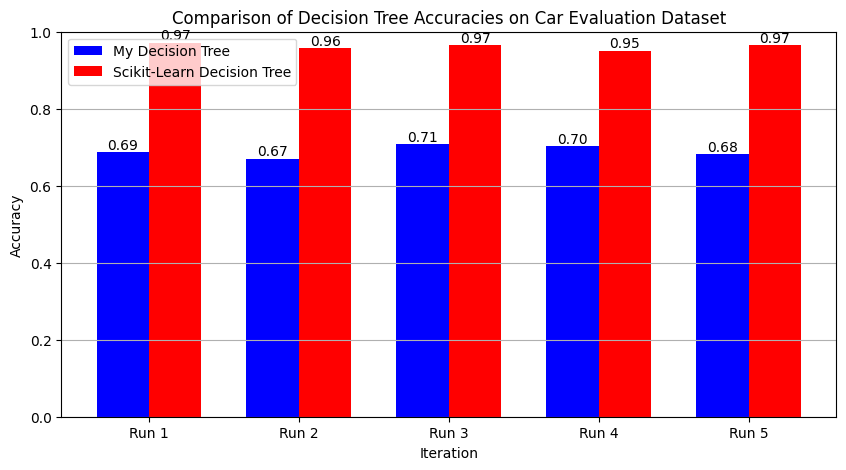

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Load the car evaluation dataset
data_car = pd.read_csv("car.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Prepare the dataset
def prepare_data(data):
    X = encode_features(data.iloc[:, :-1])
    y, _ = encode_labels(data.iloc[:, -1])
    return X, y

# Prepare the car dataset
X_car, y_car = prepare_data(data_car)

# Define the grow_tree function (assuming this function is already defined)
def grow_tree(X, y, max_depth, min_samples, current_depth=0):
    # Check stopping conditions (assuming these functions are defined)
    if stop_single_class(y):
        return np.argmax(np.bincount(y))
    if stop_max_depth(current_depth, max_depth):
        return np.argmax(np.bincount(y))
    if stop_min_samples(y, min_samples):
        return np.argmax(np.bincount(y))
    if stop_unbalanced(y):
        return np.argmax(np.bincount(y))

    # Find the best feature to split on
    best_feature = best_feature_to_split(X, y)

    # Split the data based on the best feature
    X_left, X_right, y_left, y_right = split_data(X, y, best_feature)

    # If no split is possible, return a leaf node
    if len(y_left) == 0 or len(y_right) == 0:
        return np.argmax(np.bincount(y))

    # Recursively grow the left and right subtrees
    left_child = grow_tree(X_left, y_left, max_depth, min_samples, current_depth + 1)
    right_child = grow_tree(X_right, y_right, max_depth, min_samples, current_depth + 1)

    # Return the current node
    return {
        "feature": best_feature,
        "left_child": left_child,
        "right_child": right_child
    }

# Define the predict_with_tree function
def predict_with_tree(tree, x):
    if not isinstance(tree, dict):
        return tree  # Return the class label at the leaf node

    feature_index = tree['feature']
    threshold = np.mean(x[feature_index])  # Use the mean for splitting
    if x[feature_index] < threshold:
        return predict_with_tree(tree['left_child'], x)  # Go left
    else:
        return predict_with_tree(tree['right_child'], x)  # Go right

# Initialize lists to store accuracies
my_tree_accuracies = []
sklearn_accuracies = []

# Number of iterations for testing
n_iterations = 5

# Loop for training and testing
for _ in range(n_iterations):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_car, y_car, test_size=0.2, random_state=None)

    # Hyperparameter tuning for scikit-learn's decision tree model
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions with the best scikit-learn model
    sklearn_predictions = best_model.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)

    # Train your decision tree model
    my_tree = grow_tree(X_train, y_train, max_depth=5, min_samples=5)

    # Make predictions with your decision tree
    my_predictions = [predict_with_tree(my_tree, x) for x in X_test]
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_tree_accuracies.append(my_accuracy)

# Calculate final accuracy rates
final_my_tree_accuracy = np.mean(my_tree_accuracies)
final_sklearn_accuracy = np.mean(sklearn_accuracies)

# Print final accuracy rates
print(f"Final Accuracy of My Decision Tree Model: {final_my_tree_accuracy:.2f}")
print(f"Final Accuracy of Scikit-Learn Decision Tree Model: {final_sklearn_accuracy:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
x = np.arange(n_iterations)
width = 0.35

# Create bars for both models
bars1 = plt.bar(x - width/2, my_tree_accuracies, width, label='My Decision Tree', color='blue')
bars2 = plt.bar(x + width/2, sklearn_accuracies, width, label='Scikit-Learn Decision Tree', color='red')

# Add accuracy labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies on Car Evaluation Dataset')
plt.xticks(x, [f'Run {i+1}' for i in x])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Class distribution: Counter({1: 71, 0: 59, 2: 48, 3: 1})
Final Accuracy of My Decision Tree Model (Raw Data): 0.31
Final Accuracy of Scikit-Learn Decision Tree Model (Raw Data): 0.46
Final Accuracy of My Decision Tree Model (Scaled Data): 0.31
Final Accuracy of Scikit-Learn Decision Tree Model (Scaled Data): 0.44


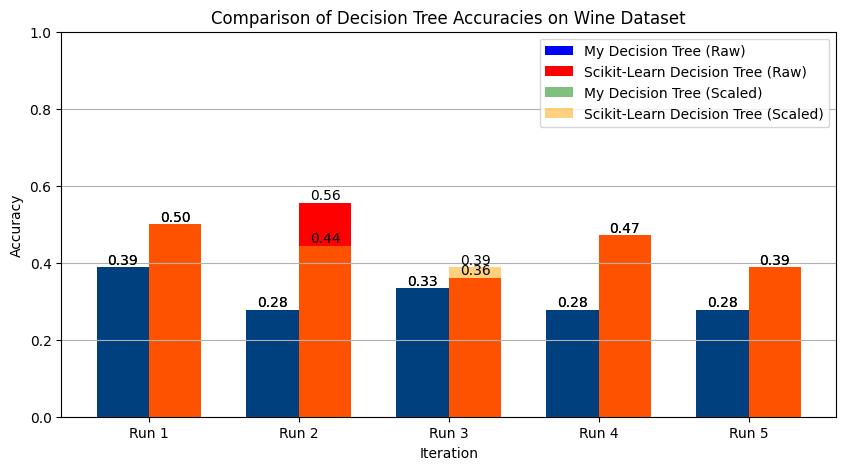

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# Load the wine dataset
data_wine = pd.read_csv("wine.csv")

# Function to encode categorical labels to integers
def encode_labels(y):
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_int[label] for label in y]), label_to_int

# Function to convert categorical features to numeric
def encode_features(X):
    return pd.get_dummies(X).to_numpy()

# Prepare the dataset
def prepare_data(data):
    X = encode_features(data.iloc[:, :-1])
    y, _ = encode_labels(data.iloc[:, -1])
    return X, y

# Prepare the wine dataset
X_wine, y_wine = prepare_data(data_wine)

# Check class distribution
class_distribution = Counter(y_wine)
print("Class distribution:", class_distribution)

# Remove classes with insufficient samples
min_samples = 2  # Minimum samples required for each class
classes_to_keep = [cls for cls, count in class_distribution.items() if count >= min_samples]
mask = np.isin(y_wine, classes_to_keep)
X_wine_filtered = X_wine[mask]
y_wine_filtered = y_wine[mask]

# Initialize lists to store accuracies
my_tree_accuracies = []
sklearn_accuracies = []
my_tree_accuracies_scaled = []
sklearn_accuracies_scaled = []

# Number of iterations for testing
n_iterations = 5

# Loop for training and testing
for _ in range(n_iterations):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_wine_filtered, y_wine_filtered, test_size=0.2, stratify=y_wine_filtered, random_state=None)

    # Train and test on non-preprocessed data
    # Hyperparameter tuning for scikit-learn's decision tree model
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions with the best scikit-learn model
    sklearn_predictions = best_model.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)

    # Train your decision tree model
    my_tree = grow_tree(X_train, y_train, max_depth=5, min_samples=5)

    # Make predictions with your decision tree
    my_predictions = [predict_with_tree(my_tree, x) for x in X_test]
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_tree_accuracies.append(my_accuracy)

    # Now, scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and test on preprocessed (scaled) data
    # Hyperparameter tuning for scikit-learn's decision tree model
    grid_search_scaled = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    grid_search_scaled.fit(X_train_scaled, y_train)

    # Best model from grid search
    best_model_scaled = grid_search_scaled.best_estimator_

    # Make predictions with the best scikit-learn model
    sklearn_predictions_scaled = best_model_scaled.predict(X_test_scaled)
    sklearn_accuracy_scaled = accuracy_score(y_test, sklearn_predictions_scaled)
    sklearn_accuracies_scaled.append(sklearn_accuracy_scaled)

    # Train your decision tree model on scaled data
    my_tree_scaled = grow_tree(X_train_scaled, y_train, max_depth=5, min_samples=5)

    # Make predictions with your decision tree on scaled data
    my_predictions_scaled = [predict_with_tree(my_tree_scaled, x) for x in X_test_scaled]
    my_accuracy_scaled = accuracy_score(y_test, my_predictions_scaled)
    my_tree_accuracies_scaled.append(my_accuracy_scaled)

# Calculate final accuracy rates
final_my_tree_accuracy = np.mean(my_tree_accuracies)
final_sklearn_accuracy = np.mean(sklearn_accuracies)
final_my_tree_accuracy_scaled = np.mean(my_tree_accuracies_scaled)
final_sklearn_accuracy_scaled = np.mean(sklearn_accuracies_scaled)

# Print final accuracy rates
print(f"Final Accuracy of My Decision Tree Model (Raw Data): {final_my_tree_accuracy:.2f}")
print(f"Final Accuracy of Scikit-Learn Decision Tree Model (Raw Data): {final_sklearn_accuracy:.2f}")
print(f"Final Accuracy of My Decision Tree Model (Scaled Data): {final_my_tree_accuracy_scaled:.2f}")
print(f"Final Accuracy of Scikit-Learn Decision Tree Model (Scaled Data): {final_sklearn_accuracy_scaled:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
x = np.arange(n_iterations)
width = 0.35

# Create bars for both models
bars1 = plt.bar(x - width/2, my_tree_accuracies, width, label='My Decision Tree (Raw)', color='blue')
bars2 = plt.bar(x + width/2, sklearn_accuracies, width, label='Scikit-Learn Decision Tree (Raw)', color='red')
bars3 = plt.bar(x - width/2, my_tree_accuracies_scaled, width, label='My Decision Tree (Scaled)', color='green', alpha=0.5)
bars4 = plt.bar(x + width/2, sklearn_accuracies_scaled, width, label='Scikit-Learn Decision Tree (Scaled)', color='orange', alpha=0.5)

# Add accuracy labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies on Wine Dataset')
plt.xticks(x, [f'Run {i+1}' for i in x])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!